In [1]:
import rioxarray as rxr
import gval

## Load Datasets

It is preferred to use masking and scaling by default.  If your original data does not have nodata or does not have nodata assigned, please assign using: `rio.set_nodata(<your_nodata_value>)`

In [2]:
candidate = rxr.open_rasterio('candidate_map_two_class_categorical.tif', mask_and_scale=True)
benchmark = rxr.open_rasterio('benchmark_map_two_class_categorical.tif', mask_and_scale=True)

## Run GVAL Categorical Compare

An example of running the entire process with one command using minimal arguments is deomnstrated below.

In [3]:
agreement_map, crosstab_table, metric_table = candidate.gval.categorical_compare(benchmark,
                                                                                 positive_categories=[2],
                                                                                 negative_categories=[0,1])

/home/sven/miniconda3/envs/gval2/lib/python3.10/site-packages/xarray/core/computation.py:769: RuntimeWarning: invalid value encountered in szudzik_pair_signed
  result_data = func(*input_data)


## Output

#### Agreement Map

The agreement map compares the encodings of the benchmark map and candidate map using a "comparison function" to then output unique encodings.  In this particular case the "Szudzik" comparison function was used by default since no argument was passed in for the `comparison_function` argument.  The Szudzik function is as follows:

$
c = \text{candidate value} \\
b = \text{benchmark value} \\
f(x)= 
\begin{cases}
    c^{2} + c + b,& \text{if } c\geq b\\
    b^{2} + c,              & \text{otherwise}
\end{cases}$


The resulting map allows a user to visualize these encodings as follows:

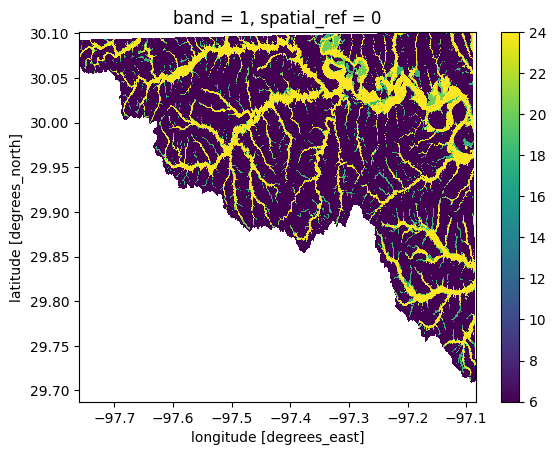

In [4]:
agreement_map.plot()

#### Cross-tabulation Table

A cross-tabulation table displays the frequency of each class in the presence of another within the spatial unit of interest. (In this case a pixel in each raster dataset.)  This can then be used to compute categorical statistics.

In [5]:
crosstab_table

,band,candidate_values,benchmark_values,counts,conditions
0,1,1.0,0.0,10345720.0,tn
1,1,2.0,0.0,512277.0,fp
2,1,1.0,2.0,639227.0,fn
3,1,2.0,2.0,2473405.0,tp


#### Metric Table

A metric table contains information about the unit of analysis, (a single band in this case), and selected categorical statistics.  This is done by specifying the positive and negative categories of each dataset and then choosing the statistics of interest.  Since we did not provide the `metrics` argument GVAL computed all of the available categorical statistics.  (<b>Note: if there is no negative class encoding all statistics computing negatives will be skipped.</b>)

In [6]:
metric_table

,band,fn,fp,tn,tp,accuracy,critical_success_index,f_score,false_discovery_rate,false_negative_rate,...,fowlkes_mallows_index,matthews_correlation_coefficient,negative_likelihood_ratio,negative_predictive_value,positive_likelihood_ratio,positive_predictive_value,prevalence,prevalence_threshold,true_negative_rate,true_positive_rate
0,1,639227.0,512277.0,10345720.0,2473405.0,0.917577,0.682336,0.811177,0.171578,0.205365,...,0.811352,0.758757,0.215534,0.941809,16.842723,0.828422,0.213711,0.195925,0.95282,0.794635


## Access to Individual GVAL Operations

Aside form running the entire process, it is possible to run each of the following steps individually: spatial alignment, computing an agreement map, computing a cross-tabulation table, and computing a metric table. 

#### Spatial Alignment

In [7]:
candidate, benchmark = candidate.gval.spatial_alignment(benchmark)

#### Agreement Map

In [8]:
agreement_map = candidate.gval.compute_agreement_map(benchmark, 'szudzik')

/home/sven/miniconda3/envs/gval2/lib/python3.10/site-packages/xarray/core/computation.py:769: RuntimeWarning: invalid value encountered in szudzik_pair_signed
  result_data = func(*input_data)


#### Cross-tabulation Table

In [9]:
crosstab_table = candidate.gval.compute_crosstab(benchmark)

#### Metric Table

In [10]:
# pandas accessor
metrics = []
metric_table = crosstab_table.gval.compute_metrics(negative_categories= [0, 1],
                                                   positive_categories = [2])

## Save Output

Finally, one can take the results and save them to a directory of their choice.  The following is an example of saving the agreement map and then the metric table:

In [11]:
# output agreement map
agreement_file = 'agreement_map.tif'
metric_file = 'metric_file.csv'

agreement_map.rio.to_raster(agreement_file)
metric_table.to_csv(metric_file)